In [2]:
import tensorflow as tf

import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [18]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

In [4]:
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')

# https://commons.wikimedia.org/wiki/File:Vassily_Kandinsky,_1913_-_Composition_7.jpg
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

196608/195196 [==============================] - 0s 1us/step


In [9]:
# image를 load하기 위한 함수
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

In [7]:
# show image function
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
    
    plt.imshow(image)
    if title:
        plt.title(title)

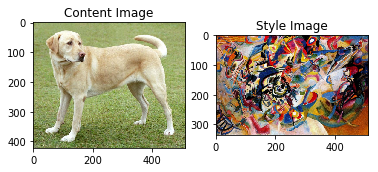

In [11]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1,2,1)
imshow(content_image, title='Content Image')

plt.subplot(1,2,2)
imshow(style_image, title='Style Image')

# TF-Hub를 이용한 Fast Style Transfer

In [19]:
!pip install tensorflow_hub
import tensorflow_hub as hub
hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/1')
stylized_image = hub_module(tf.constant(content_image), tf.constant(style_image))[0]
transform_image = tensor_to_image(stylized_image)

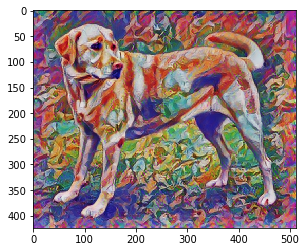

In [21]:
plt.imshow(transform_image)

## Content와 Style 표현 정의
이미지의 콘텐츠와 스타일 표현을 얻기 위해, model 내 중간 레이어(layer)를 살펴보겠습니다. 중간 레이어들은 피쳐맵(feature map)을 나타나는데 이는 깊어질수록 높이가 커지게 됩니다. 이번 경우, 미리 학습된 이미지 분류 신경망인 VGG19 신경망을 사용합니다. 이 신경망의 중간 레이어들은 이미지의 스타일과 콘텐츠 표현을 정의하는 데 필요합니다. 중간 레이어들에서 입력 이미지의 해당 스타일 및 콘텐츠가 목적 표현에도 맞춰지도록 시도합니다.

In [22]:
content_image

<tf.Tensor: shape=(1, 422, 512, 3), dtype=float32, numpy=
array([[[[0.6290779 , 0.64868575, 0.38986227],
         [0.6007131 , 0.62248087, 0.3679772 ],
         [0.5896757 , 0.61320513, 0.3622247 ],
         ...,
         [0.5269978 , 0.55837035, 0.32699776],
         [0.49909076, 0.5304633 , 0.29732907],
         [0.47968566, 0.5110583 , 0.27576408]],

        [[0.6060711 , 0.6300001 , 0.36901602],
         [0.60180223, 0.62551117, 0.3700369 ],
         [0.6003996 , 0.623929  , 0.37294865],
         ...,
         [0.52357244, 0.554945  , 0.32141185],
         [0.5284101 , 0.5597826 , 0.3254584 ],
         [0.53133637, 0.5627089 , 0.3274148 ]],

        [[0.58011585, 0.60756683, 0.3448217 ],
         [0.5973071 , 0.6225982 , 0.36633283],
         [0.60061604, 0.6340622 , 0.3797762 ],
         ...,
         [0.530031  , 0.5614036 , 0.32610947],
         [0.5510388 , 0.58241135, 0.34711725],
         [0.55976367, 0.5911362 , 0.35584208]],

        ...,

        [[0.43124956, 0.40153953, 

In [24]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))  # content image(리트리버)
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [25]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

40960/35363 [==================================] - 0s 2us/step


[('Labrador_retriever', 0.49317113),
 ('golden_retriever', 0.23665294),
 ('kuvasz', 0.03635755),
 ('Chesapeake_Bay_retriever', 0.024182769),
 ('Greater_Swiss_Mountain_dog', 0.018646104)]

## 왜 레이어의 중간 부분을 사용하는가?
학습된 이미지 분류 신경망의 중간 레이어 출력값들이 스타일과 콘텐츠 표현을 어떻게 정의하는지 궁금할 겁니다.  
높은 단계에서, 이 현상은 신경망이 (신경망이 학습해 온)이미지 분류를 하기 위해서는 반드시 이미지를 이해해야 하는 사실로 설명될 수 있습니다. 이는 원본 이미지를 입력 픽셀(pixel)로 사용하고 원본 이미지 픽셀을 이미지 내 피쳐들의 복잡한 이해형태로 변형하는 방식으로 내부 표현을 설계합니다. 이는 CNN(Convolution Neural Network)이 얼마나 잘 일반화될 수 있는지에 대한 이유이기도 합니다. CNN은 배경이나 다른 노이즈들에 영향을 받지 않는 클래스 내에 존재하는 불변성(invariances)을 포착하고 피쳐들을 정의할 수 있습니다.  
그러므로 원본 이미지가 입력되고 분류 레이블(label)이 출력되는 구간 어딘가에서 model은 복잡한 피쳐 추출기로서 작동합니다. 따라서 중간 레이어에 접근함으로써 입력 이미지의 콘텐츠와 스타일을 설명할 수 있습니다.